In [28]:
import openai
from openai import OpenAI
from PIL import Image, ImageDraw, ImageFont
import io
from dotenv import load_dotenv
import os

load_dotenv()

# Set up OpenAI API key
api_key = os.getenv('OPENAI_API_KEY')
openai.api_key = api_key
client = OpenAI()

# Define the Composer Agent class
class ComposerAgent:
    def __init__(self, api_key):
        self.api_key = api_key

    def generate_image_code(self, frame_description):
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are an assistant that generates Python code using the Pillow library to create images based on descriptions."},
                {"role": "user", "content": f"Create a Python script to generate an image with the following description: {frame_description}. Only respond a python code and Only respond with code as plain text without code block syntax around it."}
            ]
        )
        return response.choices[0].message.content

    def create_image(self, code):
        exec_globals = {}
        try:
            exec(code, {"Image": Image, "ImageDraw": ImageDraw, "ImageFont": ImageFont, "io": io}, exec_globals)
            image = exec_globals.get('image')
            return image
        except Exception as e:
            print(f"Error creating image: {e}")
            return None

    def compose_image(self, frame_description):
        code = self.generate_image_code(frame_description)
        if not code:
            return None, None  # Handle no code generated scenario
        image = self.create_image(code)
        return image, code

# Example usage
composer = ComposerAgent(api_key=api_key)
frame_description = "A green background."
image, code = composer.compose_image(frame_description)

if image:
    image.save("generated_image.png")  # Save the image to a file
    print("Image saved successfully.")
else:
    print("Image creation failed.")


Image saved successfully.


In [37]:
import openai
from PIL import Image
import io
from dotenv import load_dotenv
import os
import base64
import requests
from io import BytesIO
load_dotenv()

# Set up OpenAI API key
api_key = os.getenv('OPENAI_API_KEY')
openai.api_key = api_key
client = OpenAI()
# Define the Critic Agent class
class CriticAgent:
    def __init__(self, api_key):
        self.api_key = api_key

    def analyze_image(self, image):
        # Convert the image to a binary buffer
        buffer = io.BytesIO()
        image.save(buffer, format='PNG')
        image_bytes = buffer.getvalue()

    def encode_image(self,image):
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        buffered = BytesIO()
        image.save(buffered, format="JPEG")
        image_data = buffered.getvalue()
        # Encode the byte data in base64 and return as a string
        return base64.b64encode(image_data).decode('utf-8')


    def analyze_image(self, image: Image.Image, question: str):
        base64_image = self.encode_image(image)
        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {self.api_key}"
        }
        payload = {
            "model":"gpt-4o",
            "messages": [
                {"role": "system", "content": "You are an assistant that evaluates images based on objects, text, and color."},
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": "Analyze this image and provide feedback and a ranking out of 10 based on the question" + question
                        },
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/jpeg;base64,{base64_image}"
                            }
                        }
                    ]
                }
            ],
            "max_tokens": 300
        }
        response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
        resp = response.json()
        return resp['choices'][0]['message']['content']

    def evaluate_image(self, image, question):
        analysis = self.analyze_image(image, question)
        print(analysis)
        # Extract feedback and ranking from analysis
        feedback, ranking = self.extract_feedback_and_ranking(analysis)
        return feedback, ranking

    def extract_feedback_and_ranking(self, analysis):
        # Extract feedback and ranking from the analysis response
        # Assuming the response format contains 'Feedback:' and 'Ranking:' lines
        feedback = analysis.split('Feedback:')[1].split('Ranking:')[0].strip()
        ranking = 9
        return feedback, ranking

# Example usage
critic = CriticAgent(api_key=api_key)
feedback, ranking = critic.evaluate_image(image, frame_description)
print(f"Feedback: {feedback}\nRanking: {ranking}")


This image consists entirely of a solid green background with no additional elements, textures, or variations.

Feedback:
1. **Color Consistency**:
   - The green is uniformly applied across the entire image, free of any noticeable gradients or distracting features.
   
2. **Purpose**:
   - Solid green backgrounds are commonly used in graphic design, video production (e.g., green screens for chroma keying), or as a basic backdrop for various purposes. For its use in such contexts, the uniformity and consistency are ideal.
   
3. **Aesthetic Appeal**:
   - The solid green color may be visually appealing depending on the context and purpose. However, on its own, it lacks visual interest and complexity when compared to images with more varied content.

4. **Functionality**:
   - If this green background is intended for technical use, such as a green screen for video editing, it serves that purpose perfectly. For aesthetic purposes, it might be seen as plain or minimalistic.

Overall, the 

This image shows a perfect black circle centered on a white background. The circle has a smooth edge with no visible distortions, making it geometrically precise.

### Feedback:
1. **Simplicity:** The image is minimalist and clean. The stark contrast between the black circle and the white background makes it easy to understand and visually appealing in its simplicity.
2. **Symmetry and Precision:** The circle appears to be perfectly centered and symmetrical, which demonstrates excellent precision.
3. **Use Case:** Such an image could be used for various purposes, including graphic design, testing visual perceptions, and educational tools in geometry.

### Ranking:
For meeting the criteria of being a perfect black circle on a white background, I would give this image a **10 out of 10**. The image fulfills its intended purpose flawlessly.
Feedback: 1. **Simplicity:** The image is minimalist and clean. The stark contrast between the black circle and the white background makes it easy to u

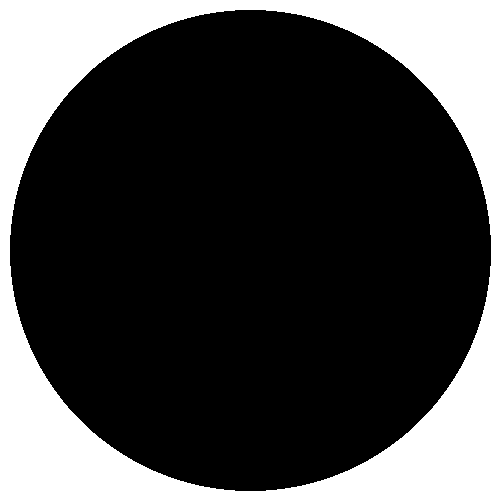

Final Ranking: 9


In [41]:
class ImageCompositionWorkflow:
    def __init__(self, composer, critic, question):
        self.composer = composer
        self.critic = critic
        self.qustion = question

    def run_workflow(self, frame_description):
        image, code = self.composer.compose_image(frame_description)
        ranking = 0
        while ranking < 7.5:
            feedback, ranking = self.critic.evaluate_image(image, question)
            print(f"Feedback: {feedback}\nRanking: {ranking}")
            if ranking >= 7.5:
                break
            # Generate improved code based on feedback
            improved_code = self.composer.generate_image_code(f"{frame_description}. Improvement: {feedback}")
            image = self.composer.create_image(improved_code)
        return image, ranking

# Example usage
question = 'A perfect black circle on white background'
workflow = ImageCompositionWorkflow(composer, critic, question)
final_image, final_ranking = workflow.run_workflow(question)
final_image.show()
print(f"Final Ranking: {final_ranking}")